In [1]:
import time
start_time = time.time()

In [2]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()
#IBMQ.save_account("4a2b1a36805ecf250f886c317cafd3bbdf55633282b8df8b8b08857d20356615132b9d174cc3a31bd54ccabf228f08658ebedf07f8b52c67619bdf0dff703bc7")

In [3]:
# Standard imports
import numpy as np
import pandas as pd
import time
import warnings

# Qiskit 
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

# Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns
from qiskit.visualization import plot_histogram
from IPython.display import clear_output

# Machine learning and preprocessing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [4]:
from sklearn.datasets import load_iris
iris_data = load_iris()

In [5]:
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

There are a few interesting observations we can find from this dataset description:

There are 150 samples (instances) in the dataset.

There are four features (attributes) in each sample.

There are three labels (classes) in the dataset.

The dataset is perfectly balanced, as there are the same number of samples (50) in each class.

We can see features are not normalized, and their value ranges are different, e.g. \[4.3,7.9\], 
 and \[01,2.5\]
 for sepal length and petal width, respectively. So, transforming the features to the same scale may be helpful.

As stated in the table above, feature-to-class correlation in some cases is very high; this may lead us to think that our model should cope well with the dataset.

We only examined the dataset description, but additional properties are available in the iris_data object. Now we are going to work with features and labels from the dataset.

In [6]:
features = iris_data.data
labels = iris_data.target

Normalize the features; transform all the features onto 0-1.

In [7]:
features = MinMaxScaler().fit_transform(features)

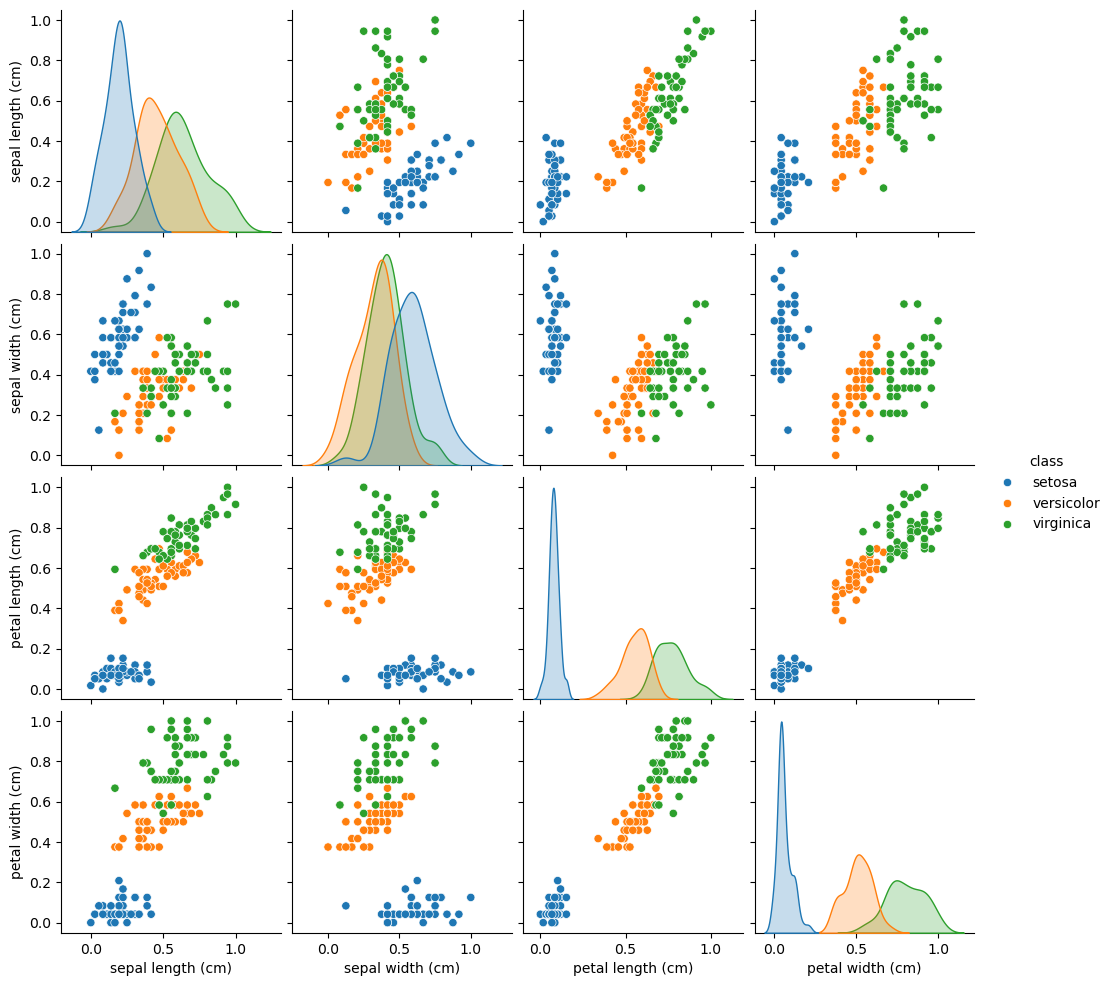

In [8]:
df = pd.DataFrame(features, columns=iris_data.feature_names)
df['class'] = [iris_data.target_names[label] for label in iris_data.target]


sns.pairplot(df, hue='class', palette='tab10')

In the pair-plot above we can observe that some 

# Training a classical model

Training a machine learning model generally involves feeding the model a section of the data, inlcuding labels, this is called 'Supervised Learning'. This will allow the model to gain an understanding of what feature values line up with the classification or label values. In general, 80% of the data set will be used for training. The other 20% will be called the 'test set'. These will be from the same data set, but will have the target label removed. It is then up to the machine learning model to attempt to classify the new data. We will then check what the model predicted for the test data against what the correct labels are to quantify how good the model will be at classifying new data. 

## Support Vector Machine (SVM)

**Support Vector Machine (SVM)** is a supervised machine learning algorithm used for both classification and regression tasks. However, it is more commonly used in classification problems. 

### Key Features:

- **Classification Boundaries**: SVMs are best known for their ability to create non-linear boundaries with the help of kernel functions.

- **Margin Maximization**: The core idea of SVM is to identify the best decision boundary (hyperplane) that separates classes in the feature space. This boundary is chosen to be the one that has the maximum margin, i.e., the maximum distance between data points of both classes.

### Applications:

- SVMs are used in applications like face detection, handwriting recognition, image classification, and many areas of biology and physics.

### Advantages:

**Versatility**: Different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

### Disadvantages:

- **Sensitivity to Noisy Data**: SVMs are sensitive to the type of kernel used and can overfit if the data is very noisy.

In [9]:
algorithm_globals.random_seed = 4701

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size = 0.8, random_state = algorithm_globals.random_seed)

In [10]:
svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

In [11]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.90


# Training a QML Model

We are training a 'Variational Quanum Classifier', or VQC. It takes a map and an ansatz and constructs a quantum neural network automatically. In the simplest case it is enough to pass the number of qubits and a quantum instance to construct a valid classifier. 

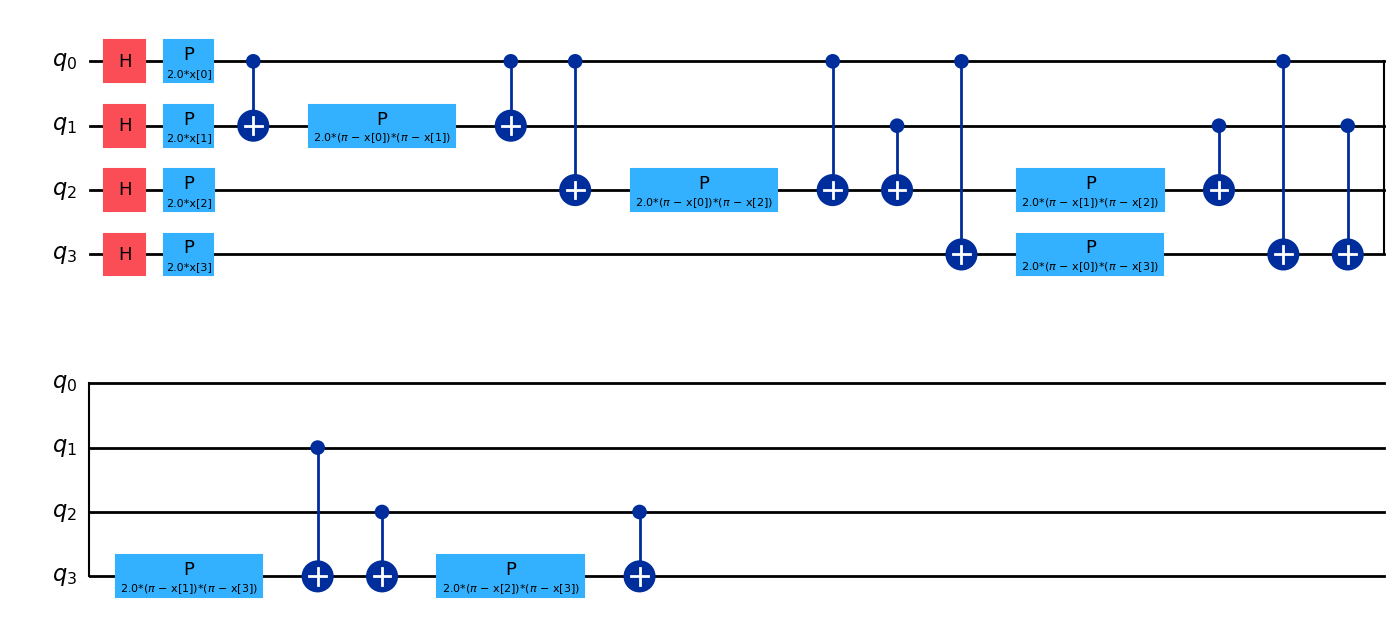

In [12]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps = 1)
feature_map.decompose().draw('mpl', fold=20)

## ZZFeatureMap
The ZZFeatureMap specifically involves the application of Z⊗Z interactions, where "Z" represents the Pauli-Z operator, applied to pairs of qubits. These interactions, combined with single-qubit rotations that encode the input data, create entangled quantum states that reflect the structure of the input data. The name ZZFeatureMap comes from the use of these ZZ interactions, which are key to the map's ability to capture and exploit correlations in the input data in a way that is uniquely quantum.

x\[0\] ,,, x\[3\] are placehoders for the features.

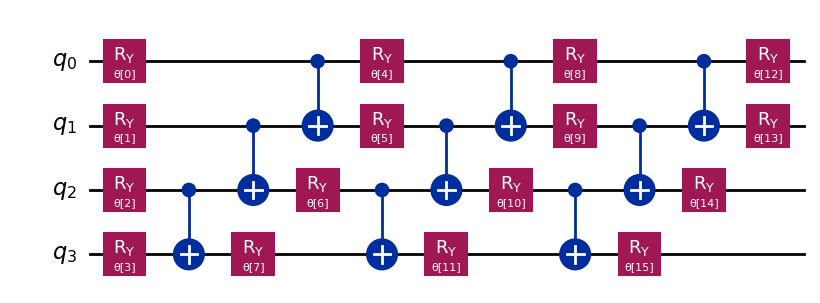

In [13]:
ansatz = RealAmplitudes(num_qubits=num_features, reps = 3)
ansatz.decompose().draw('mpl', fold = 20)

The parameters x\[0\] to x\[15\] are the trainable weights of the classifier. 

In [14]:
optimizer = COBYLA(maxiter=100)

Using a simulator to train: 

In [15]:
sampler = Sampler()

In [16]:
objective_func_vals = []

# objective function characterizes the distance between the predictions and known labeled data.

plt.rcParams['figure.figsize'] = (12,6)

def callback_graph(weights, obj_func_eval):
             
# Append the value of the objective function to an array so we 
# can plot the iteration verses the objective function value
             
             clear_output(wait=True)
             objective_func_vals.append(obj_func_eval)
             plt.title('Objective function value against Iteration')
             plt.xlabel('Iteration')
             plt.ylabel('Objective function value')
             plt.plot(range(len(objective_func_vals)), objective_func_vals)
             
             plt.show()

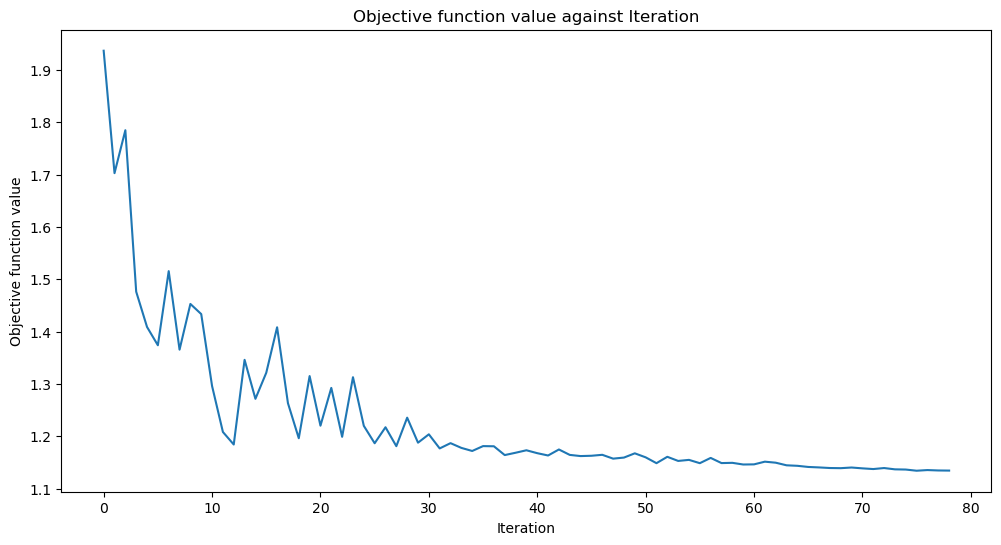

In [ ]:
vqc = VQC(
    sampler = sampler, 
    feature_map = feature_map,
    ansatz = ansatz, 
    optimizer = optimizer, 
    callback = callback_graph,)

# Clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features,train_labels)
elsapsed_time = time.time() - start 

print(f'Training time: {elsapsed_time}')

In [ ]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

# Feature Reduction

In [ ]:
features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc.fit(train_features, train_labels)

train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}") 

In [ ]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

In [ ]:
optimizer = COBYLA(maxiter=40) # reduction of iterations due to fewer qubits

In [ ]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Note the objective function is almost flattening, meaning increasing the number of iterations won't be able to increase the score. We will need to try another ansatz. 

In [ ]:
ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=40)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Better than previous. lets try increase the number of iterations. 

In [ ]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=80)

vqc2 = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc2.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_q3_eff = vqc2.score(train_features, train_labels)
test_score_q3_eff = vqc2.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q3_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q3_eff:.2f}")

In [ ]:
print(f"Model                           | Test Score | Train Score")
print(f"SVC, 4 features                 | {train_score_c4:10.2f} | {test_score_c4:10.2f}")
print(f"VQC, 4 features, RealAmplitudes | {train_score_q4:10.2f} | {test_score_q4:10.2f}")
print(f"----------------------------------------------------------")
print(f"SVC, 2 features                 | {train_score_c2:10.2f} | {test_score_c2:10.2f}")
print(f"VQC, 2 features, RealAmplitudes | {train_score_q2_ra:10.2f} | {test_score_q2_ra:10.2f}")
print(f"VQC, 2 features, EfficientSU2   | {train_score_q2_eff:10.2f} | {test_score_q2_eff:10.2f}")
   

# Feature Importance

In [ ]:
algorithm_globals.random_seed = 2024

In [ ]:
# Load the Iris dataset
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['class'] = iris.target

In [ ]:
# Map the numeric class labels to the actual species names for clarity
class_mapping = dict(zip(range(3), iris.target_names))
df['class'] = df['class'].map(class_mapping)

# Define the feature names (all features are used in this case)
feature_names = iris.feature_names

# Adjusting the number of rows in the subplots to fit the Iris dataset features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Flatten to ensure it's iterable

# Splitting the data by class
dataSetosa = df[df['class'] == 'setosa']
dataVersicolor = df[df['class'] == 'versicolor']
dataVirginica = df[df['class'] == 'virginica']

for idx, ax in enumerate(axes):
    feature = feature_names[idx]
    binwidth = (df[feature].max() - df[feature].min()) / 50  # Adjust binwidth if necessary
    # Create histograms
    ax.hist([dataSetosa[feature], dataVersicolor[feature], dataVirginica[feature]], 
            bins=np.arange(df[feature].min(), df[feature].max() + binwidth, binwidth), 
            alpha=0.5, stacked=True, density=True, label=['Setosa', 'Versicolor', 'Virginica'], color=['r', 'g', 'b'])
    ax.legend(loc='upper right')
    ax.set_title(feature)

plt.tight_layout()
plt.savefig('iris_features_hist.png')
plt.show()


In [ ]:
# Load the Iris dataset
iris_data = load_iris()

# The Iris dataset is already in a good shape for ML, so we use all features
X = iris_data.data
y = iris_data.target
feature_names = iris_data.feature_names

# Initialize the StandardScaler and scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Feature importance from the Random Forest model
feature_importances = rf_classifier.feature_importances_
print("Feature importances from Random Forest Classifier:")
for name, importance in zip(feature_names, feature_importances):
    print(f"{name}: {importance:.4f}")

# Evaluate the classifier
rf_accuracy = rf_classifier.score(X_test, y_test)
print(f"\nRandom Forest Test Accuracy: {rf_accuracy:.4f}")


In [ ]:
feature_names = iris_data.feature_names

# Sort the features by importance
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_importances = [feature_importances[i] for i in sorted_idx]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Random Forest Classifier on Iris Dataset')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [ ]:
num_features = 4

feature_map = ZZFeatureMap(feature_dimension=num_features, reps = 1)
feature_map.decompose().draw('mpl', fold=20)

In [ ]:
qc = QNNCircuit(feature_map=feature_map)
estimator_qnn = EstimatorQNN(circuit = qc)
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

using the data with all features as a baseline we can infer the importance of the features by looking the at the difference from the baseline. The larger the decrease the model performance the greater the imporance of the feature for correct classification.  

In [ ]:
# Load the Iris dataset
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
labels = iris.target

In [ ]:
# Preparing DataFrames each missing one feature
dfs = {
    "Full Features": df,
    "Missing Sepal Length": df.drop(columns=['sepal length (cm)']),
    "Missing Sepal Width": df.drop(columns=['sepal width (cm)']),
    "Missing Petal Length": df.drop(columns=['petal length (cm)']),
    "Missing Petal Width": df.drop(columns=['petal width (cm)']),
}

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Initialize variables for storing scores
classical_scores = {}

# Setting the global random seed for reproducibility
algorithm_globals.random_seed = 4701

In [ ]:
progress = {}

for description, features in dfs.items():
    # Splitting the dataset
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, y, train_size=0.8, random_state=algorithm_globals.random_seed)
    
    # Scaling the features
    train_features_scaled = scaler.fit_transform(train_features)
    test_features_scaled = scaler.transform(test_features)
    
    # Initialize variables to store progress for the current dataset variant
    iterations = range(1, 36)  # Simulating for 100 iterations
    train_scores = []
    test_scores = []
    
    warnings.filterwarnings('ignore')
    
    # Loop over the range of iterations, incrementally training the SVC
    for i in iterations:
        svc = SVC(max_iter=i)
        svc.fit(train_features_scaled, train_labels)  # fit the model
        
        # Evaluate the model
        train_score_classical = svc.score(train_features_scaled, train_labels)
        test_score_classical = svc.score(test_features_scaled, test_labels)
        
        train_scores.append(train_score)
        test_scores.append(test_score)

    progress[description] = test_scores
    
    # Store the final scores for comparison
    classical_scores[description] = {
        "Training": train_scores[-1],
        "Test": test_scores[-1]
    }

In [ ]:
plt.figure(figsize=(10, 6))
for description, scores in progress.items():
    plt.plot(iterations, scores, label=f'{description} Test Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')
plt.title('SVC Training Progress Across Dataset Variants')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
full_feature_test_score_classical = classical_scores["Full Features"]["Test"]

classical_differences = {desc: full_feature_test_score_classical - classical_scores[desc]["Test"] for desc in classical_scores if desc != "Full Features"}
descriptions = list(classical_differences.keys())
classical_diff_values = list(classical_differences.values())

In [ ]:
# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(descriptions, classical_diff_values, color='skyblue')
plt.xlabel('Configuration')
plt.ylabel('Difference in Test Accuracy from Full Features')
plt.title('Impact of Missing Features on SVC Test Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()
print("Scores and Differences from Full Features:")
for description, score_dict in classical_scores.items():
    test_score_classical = score_dict["Test"]
    difference_classical = full_feature_test_score_classical - test_score_classical if description != "Full Features" else 0
    print(f"{description}:")
    print(f"  - Classical SVC on the training dataset: {score_dict['Training']:.2f}")
    print(f"  - Classical SVC on the test dataset:     {test_score:.2f}")
    print(f"  - Difference from Full Features test score: {difference:.2f}\n")

# Quantum VC

In [ ]:
current_dataset = "Full Features"  # This should be updated dynamically in your training loop

def callback_graph(weights, obj_func_eval):
    global current_dataset
    clear_output(wait=True)
    objective_func_vals_dict[current_dataset].append(obj_func_eval)
    plt.title("Objective function value against Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    
    for description, obj_vals in objective_func_vals_dict.items():
        if obj_vals:  # Plot only if there are values
            iterations = range(len(obj_vals))
            plt.plot(iterations, obj_vals, label=description)
            # Annotate the most recent point
            plt.annotate(f"{obj_vals[-1]:.2f}",
                         (iterations[-1], obj_vals[-1]),
                         textcoords="offset points",
                         xytext=(0,10),
                         ha='center',
                         fontsize=8)

    plt.legend()
    plt.show()


In [ ]:
ansatz = EfficientSU2(num_qubits=num_features, reps=3)

In [ ]:
ansatz = RealAmplitudes(num_qubits=num_features, reps = 3)

In [ ]:
optimizer = COBYLA(maxiter=100)

In [ ]:
training_times = {}
vqc_scores = {}
objective_func_vals_dict = {
    "Full Features": [],
    "Missing Sepal Length": [],
    "Missing Sepal Width": [],
    "Missing Petal Length": [],
    "Missing Petal Width": []
}
for description, features in dfs.items():
    num_features = features.shape[1]  # Adjusted to current feature count
    
    # Dynamically adjust the feature map and ansatz for the current number of features
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = EfficientSU2(num_qubits=num_features, reps=3)
    
    # Prepare features and labels
    features_scaled = scaler.fit_transform(features)
    train_features, test_features, train_labels, test_labels = train_test_split(
        features_scaled, labels, train_size=0.8, random_state=algorithm_globals.random_seed)
    
    current_dataset = description
    
    # Initialize VQC for the adjusted feature map and ansatz
    vqc = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=callback_graph
    )
    
    # Measure training time
    start_time = time.time()
    vqc.fit(train_features, train_labels)
    elapsed_time = time.time() - start_time
    
    # Scores
    train_score_quantum = vqc.score(train_features, train_labels)
    test_score_quantum = vqc.score(test_features, test_labels)
    vqc_scores[description] = {'Training Score': train_score, 'Test Score': test_score}

    # Store elapsed time for training
    training_times[description] = elapsed_time
    print(f"Training time: {elapsed_time:.2f} seconds")

In [ ]:
full_feature_test_score_quantum = vqc_scores['Full Features']['Test Score']
quantum_differences = {desc: full_feature_test_score_quantum - vqc_scores[desc]['Test Score'] 
                       for desc in vqc_scores if desc != "Full Features"}
descriptions_quantum = list(quantum_differences.keys())
quantum_diff_values = list(quantum_differences.values())


In [ ]:
# Assuming vqc_scores is structured correctly and populated with your quantum models' scores
full_feature_test_score_quantum = vqc_scores['Full Features']['Test Score']

# Calculate the differences from the full feature set for quantum models
quantum_differences = {desc: full_feature_test_score_quantum - vqc_scores[desc]['Test Score'] 
                       for desc in vqc_scores if desc != "Full Features"}

# Prepare for plotting
descriptions_quantum = list(quantum_differences.keys())
quantum_diff_values = list(quantum_differences.values())

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(descriptions_quantum, quantum_diff_values, color='blue')
plt.xlabel('Configuration')
plt.ylabel('Difference in Test Accuracy from Full Features')
plt.title('Impact of Missing Features on Quantum Model Test Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

# Print scores and differences for quantum models
print("Quantum Scores and Differences from Full Features:")
for description, scores in vqc_scores.items():
        test_score_quantum = scores['Test Score']
        difference_quantum = full_feature_test_score_quantum - test_score_quantum
        print(f"{description}:")
        print(f"  - Quantum VQC on the training dataset: {scores['Training Score']:.2f}")
        print(f"  - Quantum VQC on the test dataset:     {test_score_quantum:.2f}")
        print(f"  - Difference from Full Features test score: {difference:.2f}\n")

In [ ]:
df_scores = pd.DataFrame({
    'Feature Set': classical_scores.keys(),
    'Classical Training Score': [score['Training'] for score in classical_scores.values()],
    'Classical Test Score': [score['Test'] for score in classical_scores.values()],
    'Quantum Training Score': [score['Training Score'] for score in vqc_scores.values()],
    'Quantum Test Score': [score['Test Score'] for score in vqc_scores.values()]
})

In [ ]:
df_scores = pd.DataFrame({
    'Feature Set': classical_scores.keys(),
    'Classical Training Score': [score['Training'] for score in classical_scores.values()],
    'Classical Test Score': [score['Test'] for score in classical_scores.values()],
    'Classical Difference': [classical_test_diff[desc] for desc in classical_scores.keys()],
    'Quantum Training Score': [score['Training Score'] for score in vqc_scores.values()],
    'Quantum Test Score': [score['Test Score'] for score in vqc_scores.values()],
    'Quantum Difference': [quantum_test_diff[desc] for desc in vqc_scores.keys()]
})

In [ ]:
df_scores

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_groups = 

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

# Classical Model Bars
classical_bars = plt.bar(index, classical_diff_values, bar_width, alpha=opacity, color='r', label='Classical')

# Quantum Model Bars
quantum_bars = plt.bar(index + bar_width, quantum_diff_values, bar_width, alpha=opacity, color='b', label='Quantum')

plt.xlabel('Configuration')
plt.ylabel('Difference from Full Feature Set')
plt.title('Test Score Differences: Quantum vs Classical Models')
plt.xticks(index + bar_width / 2, descriptions, rotation=45)  # Center labels between bars
plt.legend()

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.grid(axis='y', linestyle='--')
plt.show()


In [ ]:
end_time = time.time()
total_runtime = end_time - start_time
print(f"Total Notebook Runtime: {total_runtime} seconds")

Resources: 

- [IBM](https://qiskit.org/ecosystem/machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html) 
- [QML Summer School 2021](https://youtube.com/playlist?list=PLOFEBzvs-VvqJwybFxkTiDzhf5E11p8BI&si=zTRQ8YI7knonf7Nw)